In [34]:
import gensim.models
import gensim.corpora
import gensim as gs
import pyLDAvis as pvis
import pyLDAvis.gensim
import gensim.models.coherencemodel
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score
from gensim.models import FastText
from sklearn.metrics import classification_report
from joblib import dump, load
from gensim.models.phrases import Phrases, Phraser

In [197]:
def load_lex_data(dataset_name, feature_set):
    print("loading lex data for", dataset_name)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", dtype = types)
    
    targets = dataset["a"]
    inputs = dataset[feature_set]
    #inputs = dataset[["wc", "ewc", "hc", "ac", "fc"]]
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def load_vector_data(dataset_name, bgr=False):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",", dtype = types).astype(str)["a"].tolist() 
    vector_model = FastText.load("../models/word_embeddings/" + dataset_name + "_fasttext")
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    tokenized = sentences
    if bgr:
        bigram = Phraser(Phrases(sentences))
        bigrammed = [bigram[sentence] for sentence in sentences]
        tokenized = bigrammed
    inputs = [np.sum(vector_model.wv[sent], 0).tolist() if sent else np.zeros(32) for sent in tokenized]   
    inputs = np.array(inputs)
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y  

def load_topic_data(dataset_name, num_topics):
    print("loading topic data for", dataset_name)
    # load inputs and labels
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv").astype(str).values.tolist() 
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", dtype = types)["a"].tolist()
    # remove placeholders from the stems dataset
    for index, sample in enumerate(dataset): 
            dataset[index] = list(filter((" ").__ne__, sample))
    # create dic, copora and lda-model
    dic = gs.corpora.Dictionary(dataset)
    corpus = [dic.doc2bow(sample) for sample in dataset]
    lda_model = gensim.models.ldamulticore.LdaMulticore.load("../models/topic_models/" + dataset_name + "_ldamodel")
    
    vecs = []
    # for every sentence in the dataset make topic vectors
    for i, sample in enumerate(dataset):
        # get the vector-representations from the doc
        sentence = dic.doc2bow(dataset[i])
        # get the topics from the document (they are ordered by the topic ic)
        topics = lda_model.get_document_topics(sentence, minimum_probability=0.0)
        # write the probability for every topic into a single list
        topic_vec = [topics[i][1] for i in range(num_topics)] 
        # append the prob-vector for this sentence into the all-vectors-list
        vecs.append(topic_vec)
    dataset = vecs
    
    train_x, test_x, train_y, test_y = train_test_split(dataset, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y

def classify_with_lr(dataset_name, train_x, test_x, train_y, test_y): 
    print("building lr model")
    lr = LogisticRegression(multi_class="multinomial", solver="newton-cg", tol=0.0001, n_jobs=-1)
    print("... training model")
    lr.fit(train_x, train_y)
    print("... calcularing score")
    pred_y = lr.predict(test_x)
    # model metadata
    score, f1_scoore = lr.score(train_x, train_y), f1_score(test_y, pred_y, average="weighted")
    dump(lr, "../models/logistic_regression/" + dataset_name + "_logistic_regression.joblib") 
    return (test_y, pred_y, score, f1_scoore), lr.coef_ 
    
def draw_confusion_matrix(dataset_name, feature_set_name, test_y, pred_y, score, f1_scoore, num_topics=None): 
    print(feature_set_name)
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    if feature_set_name == "topics": desc = "dataset: {} ({}), trained with {} topics\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_topics, round(score,2), round(f1_scoore,2))
    else: desc = "dataset: {} ({}) \nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, round(score,2), round(f1_scoore,2)) 
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    fig.savefig("../img/cm_lr_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")
    
def draw_coefficients_plot(dataset_name, feature_set_name, coefficients):
    num_features = len(coefficients[0])
    fig = plt.figure()
    for i, item in enumerate(coefficients):
        plt.plot(range(len(item)), item.T, ".")#, label=classes[i]
    desc = "dataset: {} ({})".format(dataset_name, feature_set_name)
    fig.text(0.5, -0.05, desc, ha='center')
    plt.xticks(range(0, num_features), features.get(feature_set_name), rotation=90)
    plt.hlines(0, 0, num_features, linestyle="dotted")
    #plt.legend()#loc=1
    plt.grid()
    plt.show()
    fig.savefig("../img/coef_lr_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")                                                                 

In [7]:
datasets = ["emotion", "norm_emotion", "tweet", "norm_tweet"]
classes = ["happiness", "sadness", "anger", "fear"]
norm_emotion_full = ["wc", "ewc", "hc", "ac", "fc"]
num_topics_dict = {
    "norm_tweet": 79,
    "norm_emotion": 186,
    "test": 10
}
features = {
    "full": ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "nolex": ["wc", "uwc", "ewc", "cpc"],
    "lex": ["hc", "sc", "ac", "fc"]
}
types = {
    "text": object, 
    "a": int, 
    "wc": float,
    "uwc": float,
    "ewc": float,
    "cpc": float,
    "hc": float,
    "sc": float,
    "ac": float,
    "c": float
}

loading vector data for norm_tweet
... replacing placeholders
building lr model
... training model
... calcularing score
loading topic data for norm_tweet
building lr model
... training model
... calcularing score


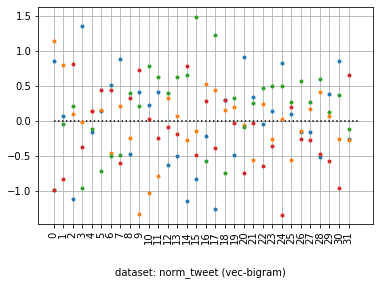

vec-bigram
no topics


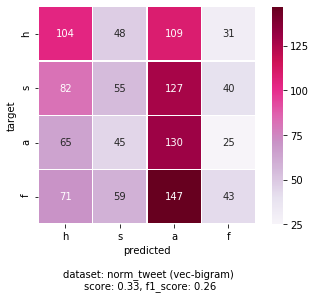

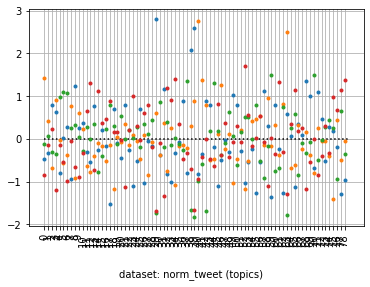

topics
topics


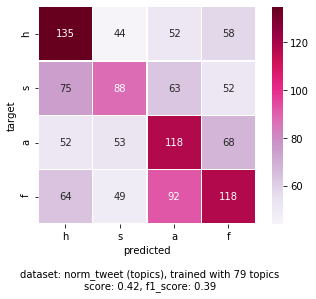

In [178]:
#train logrec over features
all_results = []
coefficients = []
topics = []

for dataset in ["norm_tweet"]: 
    topics.append(num_topics_dict[dataset])
    # lex datasets
    for key, feature_set in features.items(): 
        results, coef = classify_with_lr(dataset, *load_lex_data(dataset, feature_set))
        all_results.append([dataset, key, *results])
        coefficients.append(coef)
    # unigram dataset
    results, coef = classify_with_lr(dataset, *load_vector_data(dataset))
    all_results.append([dataset, "vec-unigram", *results])
    coefficients.append(coef)
    # bigram dataset
    results, coef = classify_with_lr(dataset, *load_vector_data(dataset, True))
    all_results.append([dataset, "vec-bigram", *results])
    coefficients.append(coef)
    # topic dataset
    results, coef = classify_with_lr(dataset, *load_topic_data(dataset, num_topics_dict[dataset]))
    all_results.append([dataset, "topics", *results])
    coefficients.append(coef)

for index, result in enumerate(all_results): 
    with open("../reports/report_lr_" + result[0] + "_"  + result[1] + ".txt", 'w') as f:
        print((result[0] + "(" + result[1] + "), f1_score: " + str(result[5]) + "):\n\n" + 
          classification_report(result[2], result[3],target_names=classes)), file=f)
    draw_coefficients_plot(result[0], result[1], coefficients[index])
    draw_confusion_matrix(*result, num_topics_dict[result[0]])